In [1]:
# Sourced from https://towardsdatascience.com/self-contained-reports-from-jupyter-notebooks-219a3887979d
# which sites source: https://stackoverflow.com/a/28073228/9988333

from IPython.display import HTML

HTML(
    """<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>"""
)

# Terminal command to convert to html with tag info
# jupyter nbconvert JupyterProjects/BookAnalysis/BookRatingAnlys.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_input_tags "remove-input" --TagRemovePreprocessor.remove_all_outputs_tags "remove-output" --no-prompt --output-dir build --template classic --to html


In [2]:
import pandas as pd
import numpy as np
from ast import literal_eval
from functools import reduce
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm
import statsmodels.stats as sms
from collections import Counter
from operator import add

In [3]:
# Set plot style
plt.rcParams['axes.grid']=True
plt.rcParams['grid.color']='gainsboro'
plt.rcParams['axes.grid.axis']='y'
plt.rcParams['axes.axisbelow']=True
plt.rcParams['axes.spines.right']=False
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.left']=False
plt.rcParams['axes.spines.bottom']=False
plt.rcParams['axes.titlesize']=17
plt.rcParams['axes.titlepad']=20
plt.rcParams['boxplot.boxprops.color']='skyblue'
plt.rcParams['figure.titlesize']=17
plt.rcParams['axes.prop_cycle']=plt.cycler(color=['skyblue']) 
plt.rcParams['hist.bins']=20
plt.rcParams['axes.facecolor']='white'

## Investigating Factors Influencing the Quality of Books

This analysis attempts to define a few rule-of-thumb measures to see if they can help to assess the quality of a book.

Factors considered are how far the author is into their career (by years and number of books published), the price and length of the book, the genre, and whether it has won an award. There is then a quick look at the ratings of books compared to their adapted movies.

Summary of contents:

   1. Introduction
   2. Summary
   3. Data Inspection and Cleaning
   4. Analysis
   5. Conclusions and Discussion
   6. Future Analysis

### 1. Introduction

So many books, so little time. Can publicly available data provide new insight on how to pick a winner? Websites such as Amazon and Goodreads provide plenty of reviews from the general public, along with other details such as when the book was published, awards it has received, cost etc. The motivation for this analysis was to see if this data could be used to develop some rules-of-thumb to guide book selection. On a personal level, there are a number of authors whose work I think I would like, so it would be useful to have a method to help pinpoint books that are better examples of an authors work. Finally, some people prefer movies to books, which leads to the question of whether a highly rated book will make for a highly rated movie.

### 2. Summary

It might be expected that the more time someone dedicates to something the better they get at it - so authors would write increasingly better books, with their best work coming towards the end of their career. There is something that can be thought of as "The Simpsons Effect" - the best seasons of The Simpsons are generally regarded as being around Seasons 3 - 7, with a slow decrease in quality after. Similarly, some authors tend to produce their best work towards the beginning of their career.

There is no clear relationship between ratings, price and length, or between ratings and different genres. The number of awards a book received explained none of the change in ratings (Rsq=0, p=0.301), however, there are significant differences when considering the type of award. Notably books that received The Man Booker prize on average have a rating 0.19 *less* than books that received no awards (p<2e-16), the Pulitzer Prize is not significantly different from no award (p=0.06) and the best performer, The Goodreads Choice Awards, are rated only 0.06 higher than no award (p<2e-16). There is a difference in the distributions for both genres and awards, pointing to a risk/reward payoff that might be useful in some situations.

There was also a significant relationship between good books and good movie adaptions, with around 15% of the variation in movie ratings being explained by the book ratings (Rsq=0.155, p=1.29e-11).

### 3. Data Inspection and Cleaning

### Data Files

There are four datafiles used, three relating to books and one to movies.

__full.csv__ Source: https://zenodo.org/record/4265096
This dataset was sourced from the GoodReads Best Books Ever list. It has information about ratings, genres, awards, price, length and the format (paperback, hardcover etc.). It has 41,756 entries.


__books.csv__ Source: https://www.kaggle.com/davidpitts2bds/30k-books-tagged-if-made-to-movie-or-not-and-more
This data was also collected from Goodreads. It contains fields for ratings, length and whether it was made into a movie. The creator notes that there are some false negatives in the "made into movie" column. It has 29,630 entries.

__booksummaries.txt__ Source: https://www.cs.cmu.edu/~dbamman/booksummaries.html
This is the CMU Book Summary Dataset, extracted from Wikipedia along with aligned metadata from Freebase. The publication dates in the other two sets was unusable (the first only has two digits for year and the second has dates for reprints rather than the original publication date), so this set is used for the publication dates. It has 10,949 entries with the dates.

__movies.csv__ Source: https://www.kaggle.com/rounakbanik/the-movies-dataset
The data is from the Full MovieLens Dataset. Only the movie titles and ratings were needed, so only the movies_metadata.csv file was used. It has 2,049 entries.

In [4]:
#Read in files and filter relevant columns
full_df = pd.read_csv("full.csv",index_col = 0,converters={'genres': literal_eval,'awards':literal_eval})
full_df = full_df[['title','author','rating','numRatings','genres','bookFormat','pages','awards','price']]

books_df = pd.read_csv("books_edit.csv",index_col = 0)
books_df = books_df[['title','author','rating','voters_count','into_movie','num-pages']]

dates_df = pd.read_csv('booksummaries.txt', delimiter = '\t',names = ['id','code','title','author','published','genres','summary'])
dates_df = dates_df[['title', 'author', 'published']]

movies_df = pd.read_csv("movies.csv",index_col = 0)
movies_df = movies_df[['title','vote_average','vote_count']]

The datasets are all fairly clean, however, only one of the book datasets have the ISBN, so they need to be joined on author and title. Both author and title have been stored differently in each set, as shown below, so those fields were homogenised before joining. 
Collections have been included as a single row which creates a lot of noise. These were filtered out using keywords, although some still were unable to be removed. 
The false negatives in the "made into movie" column were easily removed.
Some dates are yyyy-mm-dd and some are yyyy. Only the years were used, so they were converted to yyyy.

In [5]:
#Looking at books that are in both datasets to compare the formatting
full_df[full_df['author'].str.contains('J.K. Rowling')][['title','author']].head()

,title,author
1,Harry Potter and the Order of the Phoenix,"J.K. Rowling, Mary GrandPré (Illustrator)"
32,Harry Potter and the Sorcerer's Stone,"J.K. Rowling, Mary GrandPré (Illustrator)"
71,Harry Potter and the Deathly Hallows,J.K. Rowling
93,Harry Potter and the Prisoner of Azkaban,"J.K. Rowling, Mary GrandPré (Illustrator)"
103,Harry Potter and the Goblet of Fire,"J.K. Rowling, Mary GrandPré (Illustrator)"


In [6]:
#Some of the incorrect into_movie values can be seen here as well
books_df[books_df['author'].str.contains('J.K. Rowling')][['title','author','into_movie']].sort_values('title').head()

,title,author,into_movie
Unnamed: 0,,,
12555,Fantastic Beasts - The Crimes of Grindelwald: ...,J.K. Rowling,0
29979,Fantastic Beasts and Where to Find Them: The O...,J.K. Rowling,1
19455,Fantastic Beasts and Where to Find Them: The O...,J.K. Rowling,0
29072,"Harry Potter Series Box Set (Harry Potter, #1-7)",J.K. Rowling,1
404,"Harry Potter Series Box Set (Harry Potter, #1-7)",J.K. Rowling,0


In [7]:
# Removing the text after the open parenthesis in the title column for both sets
books_df['title'] = books_df['title'].str.split('\(').str[0].str.strip()
full_df['title'] = full_df['title'].str.split('\(').str[0].str.strip()
# Removing the text after the first comma in the author column for both sets
books_df['author'] = books_df['author'].str.split(',').str[0].str.strip()
full_df['author'] = full_df['author'].str.split(',').str[0].str.strip()
# Removing the into_movie duplicates
books_df = books_df.sort_values('into_movie')
books_df = books_df[~(books_df[['author','title']].duplicated(keep='last'))]
# Cleaning the dates
dates_df['published'] = pd.to_numeric(dates_df['published'].str[0:4], errors='coerce')
# There are a couple of incorrect publish dates
dates_df.loc[11333, 'published']=2005
dates_df.loc[202,'published']=1604
# Merge datasets
dfs = [full_df,books_df,dates_df]
books = reduce(lambda left,right: pd.merge(left,right,on=['title','author'],how='outer'),dfs)
# Filter key words relating to collections
books = books[~books['title'].str.contains('box set|boxed set|collection|the complete|complete works|trilogy|the stories of|omnibus|signature classics|the essential|volume set|the unabridged',case=False)]

Ratings from both data sets were combined, weighted by number of ratings. The number of pages should be the same, so where there were two values the Kaggle pages data was chosen. Books that had less than 100 total votes were removed.

In [8]:
# Fill the null values with zero
books[['rating_x','numRatings','rating_y','voters_count']] = books[['rating_x','numRatings','rating_y','voters_count']].fillna(0)
# Remove books that have less then 100 votes total
books = books[(books['numRatings']+books['voters_count'])>100]
# Create an empty column for combined ratings
books['rating'] = [None]*len(books)
# If there are no ratings and no votes, leave the ratings blank, otherwise calculate weighted rating
books['rating'] = np.where(books[['rating_x','numRatings','rating_y','voters_count']].sum(axis=1)==0, books['rating'], (books['rating_x']*books['numRatings'] + books['rating_y']*books['voters_count'])/(books['numRatings']+books['voters_count']))
# Combine page number data
books['pages'] = np.where(books['pages'].isnull(), books['num-pages'], books['pages'])
# Drop unneeded columns and duplicates
books = books.drop(columns=['rating_x','numRatings','rating_y','voters_count','num-pages'])
# Make numeric columns numeric
books[['rating','pages','price']] = books[['rating','pages','price']].apply(pd.to_numeric,errors='coerce')

The movie dataset has some duplicate rows and duplicate title entries, some of which are due to new release dates and some that have low vote counts. The duplicates and those with a low vote count are removed.

In [9]:
# Remove duplicate rows
movies_df.drop_duplicates(inplace=True)
# Remove low vote counts
movies_df = movies_df[movies_df['vote_count']>500]

### 4. Analysis

#### Q1)a) How does an author's book ratings change over their career? 

To get the best example of someone's work, should you go towards the end, middle or beginning of their career? To answer this, authors who have written a few books over time are needed, let's say at least 5 books and over at least 10 years. For consistency only fiction books are included.

In [10]:
# Remove books with no publication date
Q1_df = books[books['published'].notna()]
# Restrict books to those that have 'Fiction' in the genre field
Q1_df = Q1_df[Q1_df['genres'].notna()]
Q1_df = Q1_df[Q1_df['genres'].apply(lambda x: 'Fiction' in x)]
# Select columns required
Q1_df = Q1_df[['author', 'title','rating','published']]
# Find authors who have written at least 5 books
num_books = Q1_df.groupby(['author'],as_index=False).size()
num_books = num_books[num_books['size'] >= 5]
Q1_df = Q1_df[Q1_df['author'].isin(num_books['author'])]
# Remove anonymous authors
Q1_df = Q1_df[~Q1_df['author'].str.contains('anon',case=False)]

In [11]:
# Find the first year each author published a book
first_book = Q1_df.groupby('author',as_index=False).min()
first_book = first_book[['author','published']]
# Add this to dataframe
Q1_df = pd.merge(Q1_df,first_book,on='author',how='left')
Q1_df = Q1_df.rename(columns={'published_x':'pubDate', 'published_y':'firstBook'})
# Calculate how many years passed before each subsequent book was published
Q1_df['yearsWriting'] = Q1_df['pubDate']-Q1_df['firstBook']

In [12]:
# Create filter dataset by authors who have been writing for more than 10 years
over_ten = Q1_df.groupby(['author']).max()
over_ten = over_ten[over_ten['yearsWriting']>=10]
over_ten.reset_index(inplace=True)
Q1_df = Q1_df[Q1_df['author'].isin(over_ten['author'])]

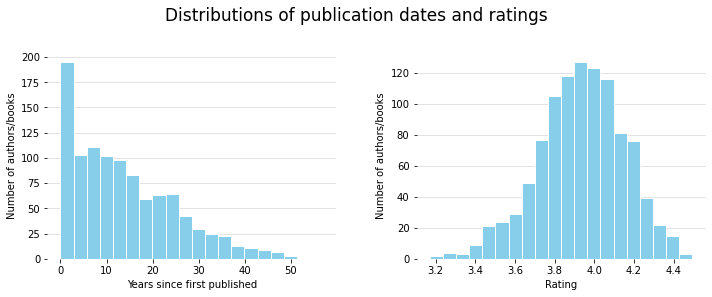

In [13]:
# Plot histograms
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[10, 4])
fig.suptitle('Distributions of publication dates and ratings', y=1.02)
 
ax[0].hist(x = Q1_df[['yearsWriting']], edgecolor='white')
ax[0].set_xlabel('Years since first published')
ax[0].set_ylabel('Number of authors/books')

ax[1].hist(Q1_df[['rating']], edgecolor='white')
ax[1].set_xlabel('Rating')
ax[1].set_ylabel('Number of authors/books')

# Increase space between plots
fig.tight_layout(w_pad=4.0)

plt.show()

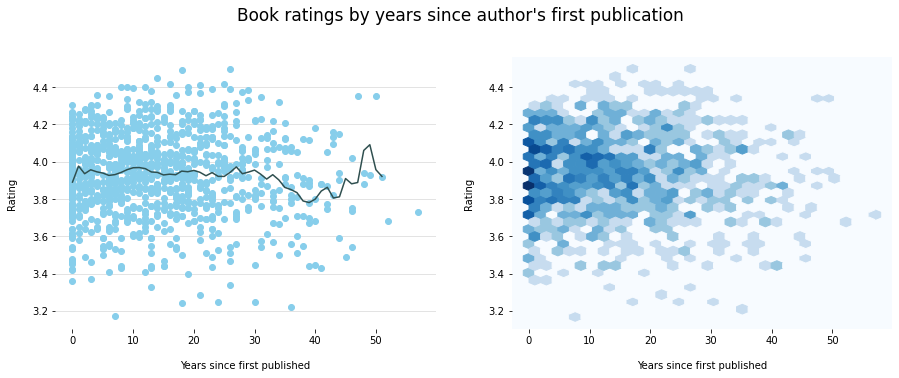

In [14]:
# Select data to plot
to_plot = Q1_df[['yearsWriting','rating']]
# Create smoothed mean line for graph
mean_line = Q1_df.groupby('yearsWriting').mean()['rating'].to_frame()
mean_line['smoothed_mean'] = mean_line.rolling(5, center=True).mean()
# Use first two raw means so mean line starts at 0
mean_line['smoothed_mean'][0:2] = mean_line['rating'][0:2]

# Settings for graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,5])

# Scatter plot with mean line
fig.suptitle('Book ratings by years since author\'s first publication', y=1.02)
ax1.set_xlabel('Years since first published', labelpad=15)
ax1.set_ylabel('Rating', labelpad=15)

ax1.scatter(
    to_plot['yearsWriting'], 
    to_plot['rating']
)

ax1.plot(
    mean_line['smoothed_mean'], 
    color='darkslategrey'
)

# Hexbin plot
ax2.set_xlabel('Years since first published', labelpad=15)
ax2.set_ylabel('Rating', labelpad=15)

ax2.hexbin(
    to_plot['yearsWriting'], 
    to_plot['rating'], 
    gridsize = 30,
    bins='log',
    cmap = 'Blues'
)
# Clean up background (using lighest colour in Blues cmap)
# Make discrete colour array from colour map
blues = cm.get_cmap('Blues', 20)
ax2.set_facecolor(blues(0))
ax2.grid(color=blues(0))

plt.show()

The mean line is fairly flat, beginning a decline at 30 years. There is an increase from 40 years onwards, but also fewer data points as time goes on so the data becomes less reliable. 

The information about some outliers and the highest/lowest rated books are presented below out of interest.

#### Late stage bangers (books rated above 4.2 after 40 years writing)

In [15]:
Q1_df[(Q1_df['rating']>4.2)&(Q1_df['yearsWriting']>40)]

,author,title,rating,pubDate,firstBook,yearsWriting
27,Dr. Seuss,"Oh, the Places You'll Go!",4.35,1990.0,1940.0,50.0
864,Theodore Dreiser,The Stoic,4.35,1947.0,1900.0,47.0


#### Late stage duds (books rated below 3.6 after 40 years writing)

In [16]:
Q1_df[(Q1_df['rating']<3.6)&(Q1_df['yearsWriting']>40)]

,author,title,rating,pubDate,firstBook,yearsWriting
643,Philip Roth,Everyman,3.590000,2006.0,1962.0,44.0
998,Lilian Jackson Braun,The Cat Who Had 60 Whiskers,3.430000,2007.0,1966.0,41.0
1059,Philip Roth,Exit Ghost,3.490000,2007.0,1962.0,45.0
1126,Arthur C. Clarke,3001: The Final Odyssey,3.540346,1997.0,1951.0,46.0


#### Ratings over 4.4

In [17]:
Q1_df[Q1_df['rating']>4.4]

,author,title,rating,pubDate,firstBook,yearsWriting
87,Terry Pratchett,Night Watch,4.495081,2002.0,1976.0,26.0
808,Patrick O'Brian,The Commodore,4.415093,1995.0,1970.0,25.0
1022,Patrick O'Brian,The Letter of Marque,4.490000,1988.0,1970.0,18.0
1034,Patrick O'Brian,The Reverse of the Medal,4.415092,1986.0,1970.0,16.0
1120,Patrick O'Brian,The Nutmeg of Consolation,4.410000,1991.0,1970.0,21.0
1125,Patrick O'Brian,The Far Side of the World,4.450000,1984.0,1970.0,14.0


#### Ratings less than 3.3

In [18]:
Q1_df[Q1_df['rating']<3.3]

,author,title,rating,pubDate,firstBook,yearsWriting
570,Don DeLillo,Falling Man,3.22000,2007.0,1971.0,36.0
608,Anne Rice,Violin,3.28506,1997.0,1976.0,21.0
686,Paul Auster,Travels in the Scriptorium,3.24000,2007.0,1989.0,18.0
938,Martin Amis,Night Train,3.25000,1997.0,1973.0,24.0
969,Charles Dickens,The Chimes,3.17000,1844.0,1837.0,7.0
1035,Don DeLillo,The Body Artist,3.25000,2001.0,1971.0,30.0


#### Q1)b) Which book is the highest rated for each author? 1st? 3rd? 7th?

In [19]:
# Sort by author then years writing and reset index so the index tracks the order books were written
Q1b_df = Q1_df.sort_values(['author','yearsWriting']).reset_index(drop=True)
# Restrict to columns needed
Q1b_df = Q1b_df[['author','title','rating']]
# Create a column with the indices so they are kept when grouping
Q1b_df = Q1b_df.reset_index(drop=False)
# Find the rows for the highest rating, the first book, and count total books for each author
best = Q1b_df.groupby('author',as_index=False).agg({'index':['first','count'],'rating':['max']})
best.columns = ['author','first','count','max']
# Inner join to get all information about the highest rated books
pub_best = pd.merge(Q1b_df, best, left_on=['author','rating'], right_on=['author','max'], how='inner')

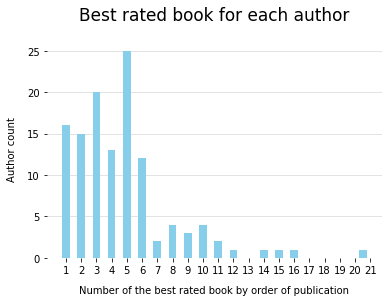

In [20]:
# Calculate which was the best rated book for each author
pub_best['bookNum'] = pub_best['index']-pub_best['first']+1

# Plot results
graph = pub_best['bookNum'].hist(
    bins = 40
)

# Set x-tick locations and values
xtloc = list(map(add,list(range(1,22)),[.25]*23))
plt.xticks(xtloc,list(range(1,22)))

graph.set_xlabel('Number of the best rated book by order of publication', labelpad=10)
graph.set_ylabel('Author count', labelpad=10)
graph.set_title('Best rated book for each author')
graph.grid(axis='x')

There is a clear peak at book number 5. Below is the same graph but broken down by how many books an author has published.

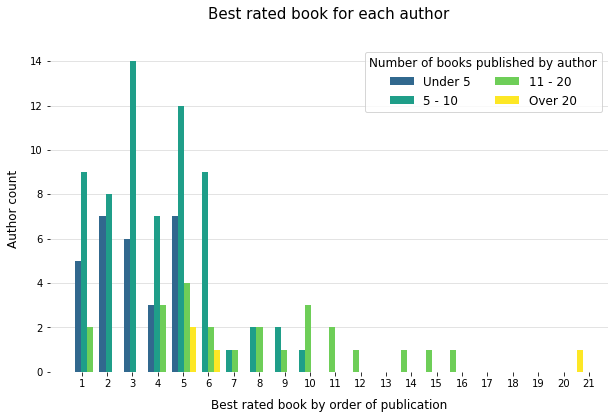

In [21]:
# Bar plot coloured by number of books 
under5 = pub_best[pub_best['count']<=5]['bookNum']
five_to_10 = pub_best[(pub_best['count']>5) & (pub_best['count']<=10)]['bookNum']
ten_to_20 = pub_best[(pub_best['count']>10) & (pub_best['count']<=20)]['bookNum']
over20 = pub_best[pub_best['count']>20]['bookNum']

# make discrete colour array from colour map
custom = cm.get_cmap('viridis', 10)

fig, ax = plt.subplots(figsize=(10,6))

multi = plt.hist(
    (under5, five_to_10, ten_to_20, over20), 
    bins = 21, 
    label = ("Under 5","5 - 10", "11 - 20", "Over 20"),
    color = (custom(3), custom(5), custom(7), custom(9)),
    align = 'mid',
    rwidth = 1
)

# Set x-tick locations and values
xtloc = list(map(add,list(range(1,22)),[.25]*23))
plt.xticks(xtloc,list(range(1,22)))

plt.xlabel('Best rated book by order of publication', fontsize=12, labelpad=10)
plt.ylabel('Author count', fontsize=12, labelpad=10)
plt.title('Best rated book for each author', fontsize=15, y =1.02)
plt.legend(title = 'Number of books published by author', ncol=2, fontsize='large', title_fontsize='large')

For many authors, their highest rated book was published towards the start of their career. For those who published 10 or less books, the third and fifth seem to be the best. The distribution is flatter for over 10 books published, but even the over 20 group still have some of their highest ratings early on. Note that there are only 4 authors who  have more than 20 books published in this dataset.

#### Q2) Is price more influenced by the rating or the length of a book? Will paying more mean a better read?

The cover type of a book can have a big influence on price, so only paperback books are considered. The distributions for price and length are both heavily right-skewed, making it harder to see the patterns. For this reason, the dataset was restricted to books with less than 1000 pages and price under $50.

In [22]:
# Filter for paperbacks and columns required
Q2_df = books[books['bookFormat'].str.contains('Paperback',case=False,na=False)]
Q2_df = Q2_df[['title','author','rating','price','pages']]
Q2_df.dropna(inplace=True)
# Filter for books with less than 1000 pages and less then $50
Q2_df = Q2_df[(Q2_df['pages']<1000)&(Q2_df['price']<50)]

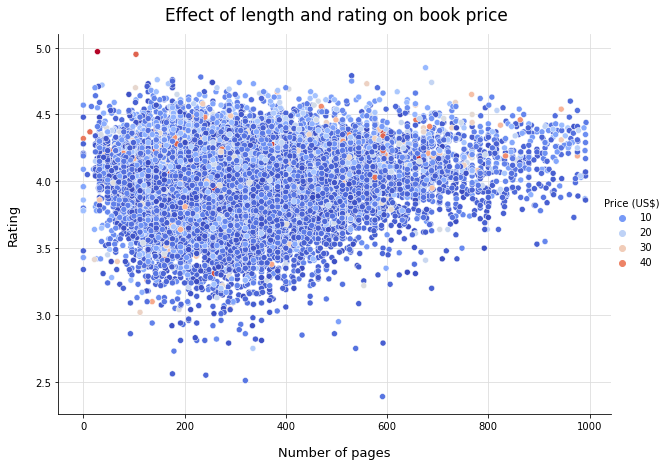

In [23]:
# Create scatterplot
prr = sns.relplot( 
    data = Q2_df,
    kind = 'scatter', 
    x = 'pages',
    y = 'rating',
    hue = 'price',
    palette = 'coolwarm',
    height=6, 
    aspect=11.7/8.27,
    facet_kws={'legend_out': True}
)

prr.fig.suptitle("Effect of length and rating on book price", fontsize=17, y = 1.04)
prr.set_xlabels("Number of pages", fontsize=13, labelpad=15)
prr.set_ylabels("Rating", fontsize=13, labelpad=15)
prr._legend.set_title("Price (US$)")
plt.grid(axis='x')

It is hard to see what is going on here, so the data is divided into "cheap" books (under $15) and more expensive ones.


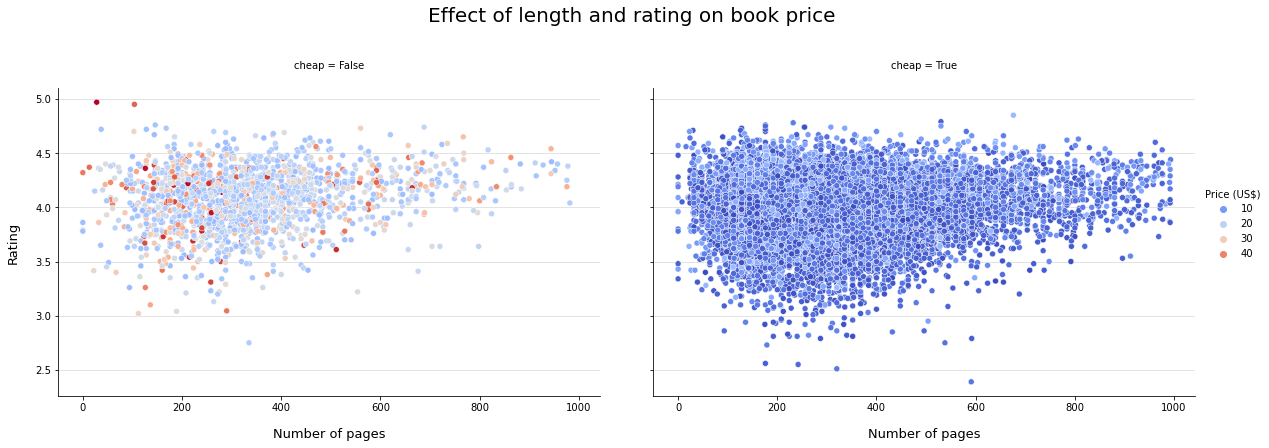

In [24]:
# Create 'cheap' boolean to seperate books
Q2_df['cheap'] = Q2_df['price']<15

prr = sns.relplot( 
    data = Q2_df,
    kind = 'scatter', 
    x = 'pages',
    y = 'rating',
    hue = 'price',
    col = 'cheap',
    palette = 'coolwarm',
    height=6, 
    aspect=11.7/8.27
)

prr.fig.suptitle("Effect of length and rating on book price", fontsize=20, y=1.03)
prr.set_xlabels("Number of pages", fontsize=13, labelpad=15)
prr.set_ylabels("Rating", fontsize=13, labelpad=15)

prr._legend.set_title("Price (US$)")
prr.tight_layout(w_pad=5.0)

The scatter plots indicate there's no clear effect here and a quick look at correlations below supports that. Cheaper books do seem to have slightly lower ratings, but longer books don't look to be more expensive. Longer books also seem to rate higher which could be noise from collections that were missed by the filter, since a collection is more likely to have a good rating. 

In [25]:
Q2_df[['rating','price','pages']].corr()

,rating,price,pages
rating,1.000000,0.144354,0.115402
price,0.144354,1.000000,-0.013663
pages,0.115402,-0.013663,1.000000


Again, out of interest, the two short, expensive books at the top left.

In [26]:
# Have a look at the two expensive, short books
Q2_df[Q2_df['rating']>4.9]

,title,author,rating,price,pages,cheap
4582,55 Celebrities With Anxiety: The Secret Weapon...,Sharon Storm,4.97,49.52,28.0,False
4585,The Genius Mind of an Anti-Vaxxer: Truth Unlea...,Sharon Storm,4.95,43.36,104.0,False


#### Q3) Are some genres more likely to have higher rated books?

In [27]:
# Filter for the required columns and remove any rows with null values
Q3_df = books[['title','author','rating','genres']]
Q3_df = Q3_df.dropna()

In [28]:
# Some list elements have 2 genres - flatten and count frequency
genres = [genre for sublist in Q3_df['genres'] for genre in sublist]
genres = Counter(genres).most_common(26)
genre_freq = pd.DataFrame(genres, columns=['genre','count'])
genre_freq = genre_freq[1:].sort_values('count')

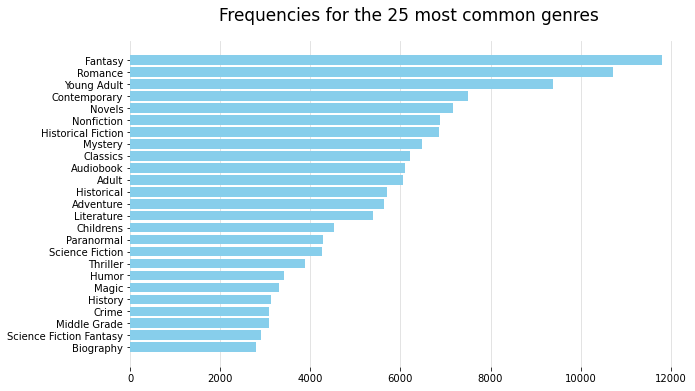

In [29]:
# Horizontal bar graph showing 25 most frequent genres
fig, ax = plt.subplots(figsize=(10, 6))

plt.barh(
    genre_freq['genre'],
    genre_freq['count']
)

ax.set_title('Frequencies for the 25 most common genres')
plt.grid(axis='both')

In [30]:
# Create set of 10 genres to plot
top_ten = ['Romance','Contemporary','Fantasy','Historical','Adventure','Classics','Mystery','Thriller','Science Fiction','Humor']
# Create empty dataset for plot
genre_bplot = pd.DataFrame([],columns = ['title','rating', 'genre'])
Q3_df.dropna(inplace=True)

# Add rating for each book with that genre in its list of genres
for genre in top_ten:
    book = Q3_df[Q3_df['genres'].apply(lambda x: genre in x)]
    frame = {'title':book['title'],'rating':book['rating'],'genre':genre}    
    new_rows = pd.DataFrame(frame)  
    genre_bplot = genre_bplot.append(new_rows)

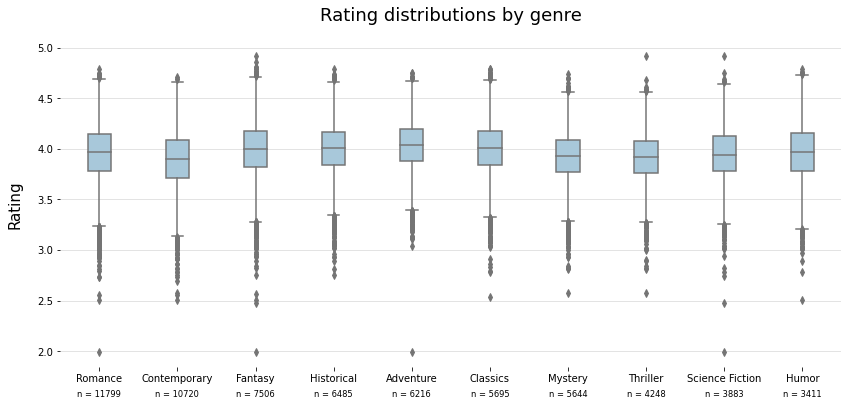

In [31]:
# Get number of observations for each genre
nobs = genre_bplot['genre'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n = " + i for i in nobs]

fig, axes = plt.subplots(figsize=(14,6))
box = sns.boxplot(
    x = genre_bplot['genre'],
    y = genre_bplot['rating'],
    width = .3,
    color = blues(7)
)
box.set_xlabel('')
box.set_ylabel('Rating',fontsize=15, labelpad=15)
box.set_title('Rating distributions by genre',fontsize=18)

# Add observation counts to the figure
xpos = range(len(nobs))
ypos = range(9)
for tick, label in zip(xpos, box.get_xticklabels()):
    box.text(xpos[tick], 1.55, nobs[tick],
            horizontalalignment='center',
            size='small',
)

The medians are fairly consistent, but there some variation in the distributions - historical and adventure  are more tightly grouped where fantasy and science fiction have a slightly flatter distribution and longer tails. 

These observations aren't independent. Most books have more than one genre and there is considerable overlap between groups, so no further analysis is done here.

#### Q4) Do awards indicate better books?

First the ratings of the book are plotted against the number of awards to see if there is a correlation. Then a comparision is made between books that have won specific awards. 
Awards selected are based on those featured at https://www.goodreads.com/award and https://gobookmart.com/10-most-prestigious-award-for-authors-and-writers-in-the-world/. Awards with less than 20 books were excluded.

In [32]:
# Filter for the required columns and remove any rows with null values
Q4_df = books[['title','author','rating','awards']]
Q4_df = Q4_df.dropna()

In [33]:
# Get number of awards each book has won
Q4_df['awardCount'] = Q4_df['awards'].apply(lambda award_list: len(award_list))

Text(0, 0.5, 'Rating')

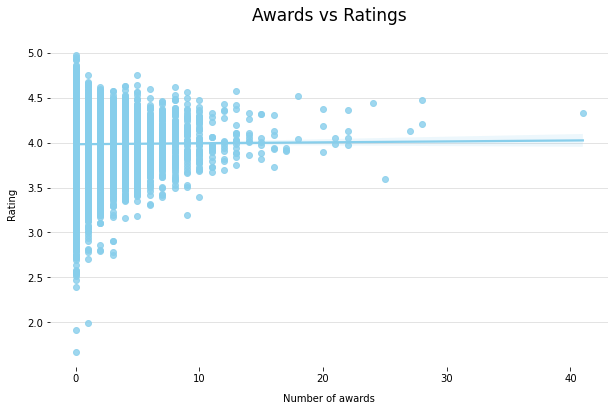

In [34]:
award_reg = Q4_df[['rating','awardCount']]

fig, ax = plt.subplots(figsize = (10,6))

sns.regplot(
    x = 'awardCount',
    y = 'rating',
    data = award_reg
)

ax.set_title('Awards vs Ratings')
ax.set_xlabel('Number of awards', labelpad=10)
ax.set_ylabel('Rating', labelpad=10)


In [35]:
# Perform linear regression
y = award_reg['rating']
x = award_reg['awardCount']
x1 = sm.add_constant(x) # adding a constant
lm = sm.OLS(y,x1).fit() # fitting the model

In [36]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.068
Date:                Wed, 15 Dec 2021   Prob (F-statistic):              0.301
Time:                        12:39:25   Log-Likelihood:                -5134.5
No. Observations:               36416   AIC:                         1.027e+04
Df Residuals:                   36414   BIC:                         1.029e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9821      0.002   2540.097      0.000       3.979       3.985
awardCount     0.0010      0.001      1.034      0.301      -0.001       0.003
==============================================================================
Omnibus:                     1587.978   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2188.306
Skew:                          -0.433   Prob(JB):                         0.00
Kurtosis:                       3.832   Cond. No.                         1.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The number of awards has no relationship to the ratings (Rsq=0, p=0.301)

In [37]:
# Create set of awards
top_awards = ['Award zero','Booker Prize','Miles Franklin','Pulitzer','Costa','Goodreads','Edgar','RITA']
# Create empty dataset for plot
awards_vplot = pd.DataFrame([],columns = ['rating', 'award'])

# Add rating for each book with that award in its list of awards
for award in top_awards:
    book = Q4_df[Q4_df['awards'].apply(lambda x: award in str(x))]
    frame = {'rating':book['rating'],'award':award}    
    new_rows = pd.DataFrame(frame)  
    awards_vplot = awards_vplot.append(new_rows)

In [38]:
# Add ratings for books that haven't received any awards
no_awards = Q4_df[Q4_df['awards'].str.len()==0]
no_awards = no_awards[['rating','awards']].rename(columns={'awards':'award'})
no_awards['award'] = 'Award zero'
awards_vplot = pd.concat([no_awards, awards_vplot])

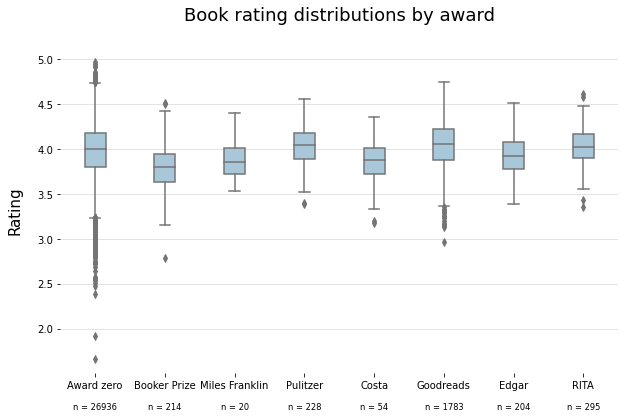

In [39]:
# Get number of observations for each award type
nobs = awards_vplot['award'].value_counts()
nobs = [nobs[award] for award in top_awards]
nobs = ["n = " + str(i) for i in nobs]

fig, axes = plt.subplots(figsize=(10,6))
box = sns.boxplot(
    x = awards_vplot['award'],
    y = awards_vplot['rating'],
    width = .3,
    color = blues(7)
)
box.set_xlabel('')
box.set_ylabel('Rating',fontsize=15, labelpad=15)
box.set_title('Book rating distributions by award',fontsize=18, y=1.02)
# Add observation counts to the figure
xpos = range(len(nobs))
ypos = range(5)
for tick, label in zip(xpos, box.get_xticklabels()):
    box.text(xpos[tick], 1.1, nobs[tick],
            horizontalalignment='center',
            size='small',
)

To compare the prizes to books with no awards, a Welch ANOVA is done followed by Dunnett's Test. The Miles Franklin and Costa awards have too few samples so are excluded.
Tests for normality and equal variances below.

In [40]:
# Set up for ANOVA
booker = awards_vplot.query('award == "Booker Prize"')['rating']
pulitzer = awards_vplot.query('award == "Pulitzer"')['rating']
goodreads = awards_vplot.query('award == "Goodreads"')['rating']
edgar = awards_vplot.query('award == "Edgar"')['rating']
rita = awards_vplot.query('award == "RITA"')['rating']
none = awards_vplot.query('award == "Award zero"')['rating']

In [41]:
awards_vplot.groupby('award').describe()

rating                                                    \
                  count      mean       std       min       25%       50%   
award                                                                       
Award zero      26936.0  3.984548  0.286633  1.670000  3.800219  4.000000   
Booker Prize      214.0  3.790961  0.265251  2.785079  3.632500  3.802578   
Costa              54.0  3.852379  0.267966  3.180000  3.721280  3.885000   
Edgar             204.0  3.924272  0.214541  3.390000  3.780000  3.930000   
Goodreads        1783.0  4.048483  0.256003  2.970000  3.882440  4.060000   
Miles Franklin     20.0  3.882258  0.234130  3.530000  3.727500  3.862578   
Pulitzer          228.0  4.031159  0.214121  3.390000  3.890000  4.050000   
RITA              295.0  4.036372  0.199782  3.360000  3.900000  4.030000   

                              
                   75%   max  
award                         
Award zero      4.1800  4.97  
Booker Prize    3.9475  4.52  
Costa           4.0175  4.36  
Edgar           4.0800  4.52  
Goodreads       4.2300  4.75  
Miles Franklin  4.0100  4.40  
Pulitzer        4.1800  4.56  
RITA            4.1700  4.62

In [42]:
# Test for normality
print('Man Booker Prize: ', scipy.stats.normaltest(booker))
print('Pulitzer Prize: ', scipy.stats.normaltest(pulitzer))
print('The Goodreads Choice Award: ', scipy.stats.normaltest(goodreads),'***')
print('The Edgar Award: ', scipy.stats.normaltest(edgar))
print('RITA Award: ', scipy.stats.normaltest(rita))
print('No awards: ', scipy.stats.normaltest(none), '***')

Man Booker Prize:  NormaltestResult(statistic=5.107901052365614, pvalue=0.0777738108305568)
Pulitzer Prize:  NormaltestResult(statistic=2.1736454444546185, pvalue=0.33728644576634276)
The Goodreads Choice Award:  NormaltestResult(statistic=56.87954880748067, pvalue=4.4541302205934914e-13) ***
The Edgar Award:  NormaltestResult(statistic=2.359730014850332, pvalue=0.3073202217491422)
RITA Award:  NormaltestResult(statistic=0.37876843912625086, pvalue=0.8274685160178017)
No awards:  NormaltestResult(statistic=1117.052423000484, pvalue=2.7236314923093435e-243) ***


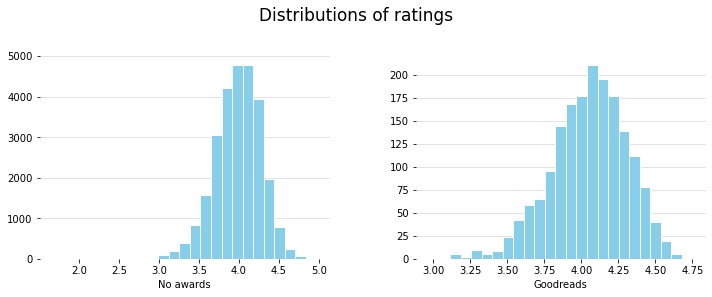

In [43]:
# No awards and Goodreads both have big sample size - eyeball distributions for normality
gr_norm = awards_vplot[awards_vplot['award']=='Goodreads']
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(no_awards['rating'],bins=25,edgecolor='white')
ax[0].set_xlabel('No awards')
ax[1].hist(gr_norm['rating'],bins=25,edgecolor='white')
ax[1].set_xlabel('Goodreads')
fig.suptitle('Distributions of ratings', y =1.02)
fig.tight_layout(w_pad=6)

In [44]:
# Unequal variances and unequal sample sizes - need to use Welch correction
#print(scipy.stats.levene(pulitzer,edgar,rita))
print('Test for equal variances: ',scipy.stats.levene(booker,pulitzer,goodreads,edgar,rita,none),'***')

Test for equal variances:  LeveneResult(statistic=22.10988349601877, pvalue=3.456598775568692e-22) ***


In [45]:
# Check the ratio of largest:smallest variance
stds = awards_vplot.groupby('award').describe()
largest_std = max(stds['rating','std']) #No awards
smallest_std = min(stds['rating','std']) #RITA
print('Ratio of largest to smallest variance: ', largest_std**2/smallest_std**2)

Ratio of largest to smallest variance:  2.058440007988861


ANOVA also requires independent samples. One book can have many awards which could violate the independence assumption. To check the similarity, this is a lower matrix showing how many times different awards are given to the same book. Naturally, books with no award never have an award. Otherwise there is minimal overlap, mainly with The Goodreads Choice Award. As the comparison is between made between books with no awards and the awards individually, it shouldn't be a problem.

In [46]:
# Create dissimilarity matrix
award_list = ['Award zero','Booker Prize','Pulitzer','Goodreads','Edgar','RITA']
dissim = pd.DataFrame(0, index=award_list, columns=award_list) # Empty matrix for results

while len(award_list)>0:    
    award = award_list.pop()  # Remove each award from the list as it is checked - result is a lower matrix
    for index, row in Q4_df.iterrows():
        if award in str(row['awards']):     # Check if the current award given to book 
            for item in row['awards']:      # Take each award given to book
                for prize in award_list:    # Check awards of interest (years are included so need to use list)
                    if prize in item:       # If found, add one to appropriate field
                        dissim[prize][award] = dissim[prize][award] + 1    
dissim

,Award zero,Booker Prize,Pulitzer,Goodreads,Edgar,RITA
Award zero,0,0,0,0,0,0
Booker Prize,0,0,0,0,0,0
Pulitzer,0,3,0,0,0,0
Goodreads,0,34,16,0,0,0
Edgar,0,0,1,23,0,0
RITA,0,0,0,18,0,0


In [47]:
sms.oneway.anova_oneway((booker,pulitzer,goodreads,edgar,rita,none), welch_correction=True)

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 52.98084321664306
pvalue = 2.5180982652975606e-46
df = (5.0, 667.7997813052062)
df_num = 5.0
df_denom = 667.7997813052062
nobs_t = 29660.0
n_groups = 6
means = array([3.79096136, 4.03115871, 4.04848271, 3.9242717 , 4.03637166,
           3.98454849])
nobs = array([  214.,   228.,  1783.,   204.,   295., 26936.])
vars_ = array([0.070358  , 0.04584779, 0.06553732, 0.04602772, 0.03991293,
           0.08215836])
use_var = 'unequal'
welch_correction = True
tuple = (52.98084321664306, 2.5180982652975606e-46)

In [48]:
# Save awards/ratings to csv so they can be accessed in R
awards_anv = awards_vplot[awards_vplot['award'].isin({'Award zero','Booker Prize','Pulitzer','Goodreads','Edgar','RITA'})]
awards_anv.to_csv('awards.csv', index=False)

    # Perform Dunnett's test in R
    awards <- read.csv("awards.csv", header = TRUE)

    library(DescTools)
    DT = DunnettTest(x=awards$rating, g=as.factor(awards$award))
    DT

    # Create data frame for confidence intervals
    diff = DT$`Award zero`[1:7]
    lwr.ci = DT$`Award zero`[8:14]
    upr.ci = DT$`Award zero`[15:21]
    name = sort(unique(awards$award))[-1]
    CIs = data.frame(name,lwr.ci,diff,upr.ci)

    # Save CIs data frame to use in Python
    write.csv(CIs,"awardCIs.csv")

#### R output
    Dunnett's test for comparing several treatments with a control :  
                95% family-wise confidence level

                                   diff       lwr.ci       upr.ci   pval    
    Booker Prize-Award zero -0.19358712 -0.243553341 -0.143620907 <2e-16 ***
    Edgar-Award zero        -0.06027678 -0.111443587 -0.009109982 0.0122 *  
    Goodreads-Award zero     0.06393423  0.046130645  0.081737812 <2e-16 ***
    Pulitzer-Award zero      0.04661023 -0.001810119  0.095030570 0.0647 . 
    RITA-Award zero          0.05182317  0.009202602  0.094443737 0.0088 ** 


In [49]:
# Read in data frame with confidence intervals
CIs = pd.read_csv("awardCIs.csv", dtype={'diff':float,'lwr.ci':float,'upr.ci':float}, index_col=0)

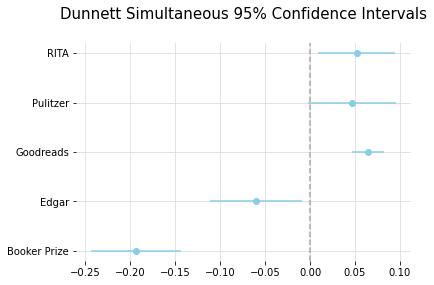

In [50]:
# Plot confidence intervals
plt.errorbar(
    x=CIs['diff'],
    y=CIs['name'],
    xerr=(CIs['upr.ci']-CIs['diff']),
    fmt='o'
)
plt.axvline(x=0,color='darkgrey',ls='--')
plt.title('Dunnett Simultaneous 95% Confidence Intervals',fontsize=15,y=1.02)
plt.grid(axis='x')

The Goodreads Choice Award (p<2e-16) and the RITA Award (by Romance Writers of America, p=0.0088) rate significantly higher than no award.
The Pulitzer Prize shows no significant difference (p=0.0647).
The Man Booker Prize (p<2e-16) and the Edgar Award (p=0.0122) rate significantly worse than books that haven't received any awards.
The differences in means are very small (-0.19 to +0.06), suggesting that there is not much practical information about the rating of a book given by its award status.

#### Q5) Will a good book make a good movie? Is there a correlation between book ratings and ratings of the movie adapted from the book?

There are some titles with more than one movie rating. As seen before, this is likely due to more than one film being made from a book, so this data should be kept. An average of the film ratings can be taken.


In [51]:
#Filter movies for required columns and take mean of title ratings
Q5_mov = movies_df[['title','vote_average']]
Q5_mov = Q5_mov.groupby(['title']).mean()
Q5_mov.reset_index(inplace=True)

In [52]:
#Filter for books that have been adapted
Q5_df = books[books['into_movie']==1]
Q5_df = Q5_df[['title','rating']]
#Merge datasets
Q5_df = pd.merge(Q5_df,Q5_mov,on='title')

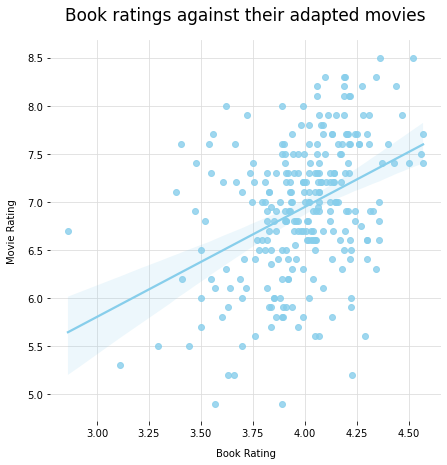

In [53]:
bk_mov=Q5_df[['rating','vote_average']]
bk_mov = bk_mov[bk_mov['rating']>1]

fig, ax = plt.subplots(figsize = (7,7))

sns.regplot(
    x = 'rating',
    y = 'vote_average',
    data = Q5_df,
    color = 'skyblue'
)

ax.set_title('Book ratings against their adapted movies', fontsize=17)
ax.set_xlabel('Book Rating', labelpad=10)
ax.set_ylabel('Movie Rating', labelpad=10)
ax.grid(color='gainsboro')
ax.set_axisbelow(True)


In [54]:
Q5_y = Q5_df['vote_average']
Q5_x = Q5_df['rating']
Q5_x = sm.tools.tools.add_constant(Q5_x) # adding a constant
lm = sm.regression.linear_model.OLS(Q5_y,Q5_x).fit() # fitting the model

In [55]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           vote_average   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     50.11
Date:                Wed, 15 Dec 2021   Prob (F-statistic):           1.29e-11
Time:                        12:39:38   Log-Likelihood:                -266.75
No. Observations:                 268   AIC:                             537.5
Df Residuals:                     266   BIC:                             544.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3730      0.645      3.678      0.000       1.103       3.643
rating         1.1429      0.161      7.079      0.000       0.825       1.461
==============================================================================
Omnibus:                        3.610   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                3.681
Skew:                          -0.277   Prob(JB):                        0.159
Kurtosis:                       2.848   Cond. No.                         68.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model indicates a significant effect (p=1.29e-11) which accounts for a small part of the movie ratings (Rsq=0.155).

### 5. Conclusions and Discussion

There were a couple of clear and useful results here. Firstly, that many authors produce their best work towards the beginning of their career. This pattern can be seen in other artistic mediums - TV shows, music, even mathematics. There were some authors that produced their best works later, so this isn't a hard and fast rule. Also this analysis does not make an attempt to understand why some peak early and some later. It does fit the requirement of being a simple, easy to implement guide.

Second, awards seem to have no objective bearing on ratings - the difference in means between all award groups was less than 0.25 and there was no effect of the number of awards on the ratings (Rsq=0, p=0.301). What was noticible was the difference in distributions. Remembering that these results are a collection of reviews by the general population, it is interesting that books with awards tended to have fewer very bad reviews, but also fewer very good reviews. This points to a risk/reward situation. If a book was, for example, intended as a present, it would be advisable to get one with an award as there is less chance of getting a bad book. On the other hand, if the intention was to get an exceptionally good book, it would be better to take a risk and get one that hasn't won any awards. 

There was a relationship between good books and better rated adpated movies, but it only explained a small amount of the variance (p=1.29e-11, Rsq=0.155). On its own it might not be useful in selecting a good film, but it could be useful when considered along with other factors.

The length of time someone has been writing for is not a good indicator of rating in this data set. With more information, particularly about those who have been writing for over 20 years, it may be possible to get a more certain answer. Different genres were also fairly consistent. Again, there is considerable overlap between them making it hard to tease apart an effect. Genre is also very subjective - people have their favourites. 

Ultimately there are two key things this analysis points to - 1) An author's 3rd - 5th book has a good chance of being one of their best and 2) an award, no matter how prestigious, doesn't mean a better book.

### 6. Further Research

The data used to look at the best rated books by publication order is relatively small (~1,000 entries after cleaning and joining). It should be possible to get a much bigger data set by scraping the Goodreads or Amazon sites directly. This would give more clarity around the trends.

These trends could also be compared to other mediums - TV, movies, art, games - to investigate the patterns of peak quality. It is interesting that a similar trend is seen with TV shows and books, as TV shows are generally a collaborative effort with a writing team where books are generally written by one person. Being able to understand why quality declines in some scenarios could lead to methods that allow people to avoid the decline and continue to produce higher quality works.

NB: This project was initially a programming assessment and as such a literature review was not undertaken and no references are provided.